In [251]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


## Load data

In [252]:
df = pd.read_csv('./../../error_dfs/error_2019_may2021_VAR.csv', converters={'ags2': str, 'ags5': str} )
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [253]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])

In [254]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../../corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])
df

,date,ground_truth,pred,ags5,ags2,bundesland,kreis
0,2018-12-01,7.3,7.566702,01001,01,Schleswig-Holstein,"Flensburg, Stadt"
1,2019-01-01,8.2,8.038843,01001,01,Schleswig-Holstein,"Flensburg, Stadt"
2,2019-02-01,7.8,8.022765,01001,01,Schleswig-Holstein,"Flensburg, Stadt"
3,2019-03-01,7.8,7.754631,01001,01,Schleswig-Holstein,"Flensburg, Stadt"
4,2019-04-01,7.6,7.502805,01001,01,Schleswig-Holstein,"Flensburg, Stadt"
...,...,...,...,...,...,...,...
12025,2021-01-01,7.3,7.479328,16077,16,Thüringen,Altenburger Land
12026,2021-02-01,7.3,7.435923,16077,16,Thüringen,Altenburger Land
12027,2021-03-01,7.2,7.046545,16077,16,Thüringen,Altenburger Land
12028,2021-04-01,6.9,6.780956,16077,16,Thüringen,Altenburger Land


In [255]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [256]:
df['error'] = df.apply(lambda x: mean_absolute_percentage_error(x['ground_truth'], x['pred']), axis=1)

In [257]:
df

,date,ground_truth,pred,ags5,ags2,bundesland,kreis,error
0,2018-12-01,7.3,7.566702,01001,01,Schleswig-Holstein,"Flensburg, Stadt",3.653447
1,2019-01-01,8.2,8.038843,01001,01,Schleswig-Holstein,"Flensburg, Stadt",1.965335
2,2019-02-01,7.8,8.022765,01001,01,Schleswig-Holstein,"Flensburg, Stadt",2.855955
3,2019-03-01,7.8,7.754631,01001,01,Schleswig-Holstein,"Flensburg, Stadt",0.581658
4,2019-04-01,7.6,7.502805,01001,01,Schleswig-Holstein,"Flensburg, Stadt",1.278882
...,...,...,...,...,...,...,...,...
12025,2021-01-01,7.3,7.479328,16077,16,Thüringen,Altenburger Land,2.456555
12026,2021-02-01,7.3,7.435923,16077,16,Thüringen,Altenburger Land,1.861956
12027,2021-03-01,7.2,7.046545,16077,16,Thüringen,Altenburger Land,2.131325
12028,2021-04-01,6.9,6.780956,16077,16,Thüringen,Altenburger Land,1.725275


## Plot each variable

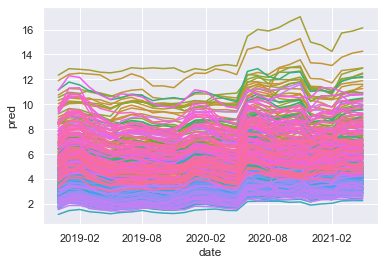

In [258]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

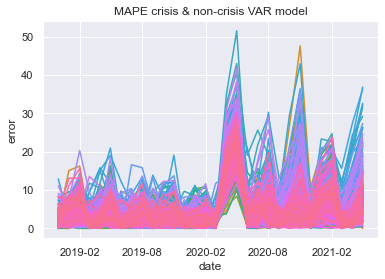

In [321]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()
g.set_title('MAPE crisis & non-crisis VAR model')
plt.savefig('MAPE_VAR_crisis.png')

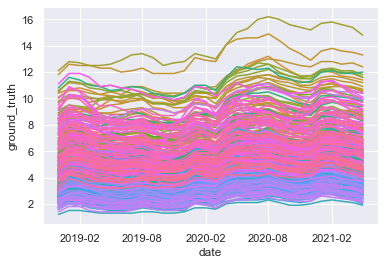

In [260]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

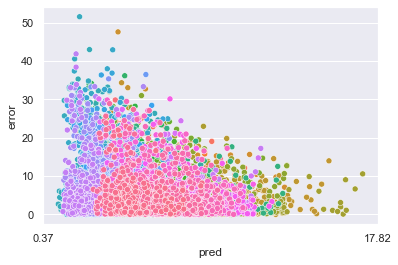

In [261]:
g = sns.scatterplot(data=df, x="pred", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

## Plot sample to compare prediction to ground truth

In [262]:
df_long = df.melt(id_vars=['date','ags5','ags2','bundesland','kreis'], var_name='y_type', value_name='vals')

In [263]:
df_long = df_long[df_long['y_type'].isin(['ground_truth','pred'])]

In [264]:
random.seed(31415)
sample_args = random.sample(list(set(df_long['ags5'])), 30)
df_sample = df_long[df_long['ags5'].isin(sample_args)]

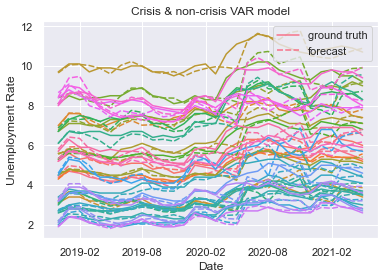

In [265]:
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.set(xlabel='Date', ylabel='Unemployment Rate')
g.set_title('Crisis & non-crisis VAR model')
plt.legend(loc='upper right', labels=['ground truth', 'forecast'])
plt.savefig('sample_ur_VAR_crisis.png')

## Look into mean errors

In [266]:
df_mean_error = df.groupby(['ags5','ags2','bundesland','kreis']).mean()
df_mean_error              

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
01001,01,Schleswig-Holstein,"Flensburg, Stadt",8.580000,8.347893,4.492331
01002,01,Schleswig-Holstein,"Kiel, Landeshauptstadt",8.110000,8.065461,3.576168
01003,01,Schleswig-Holstein,"Lübeck, Hansestadt",7.870000,7.729069,3.862208
01004,01,Schleswig-Holstein,"Neumünster, Stadt",8.566667,8.385199,3.624680
01051,01,Schleswig-Holstein,Dithmarschen,5.926667,5.888471,3.993808
...,...,...,...,...,...,...
16073,16,Thüringen,Saalfeld-Rudolstadt,5.676667,5.628680,3.775663
16074,16,Thüringen,Saale-Holzland-Kreis,4.430000,4.351722,4.736661
16075,16,Thüringen,Saale-Orla-Kreis,4.820000,4.763045,5.077284


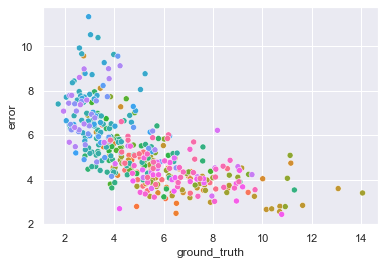

In [267]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

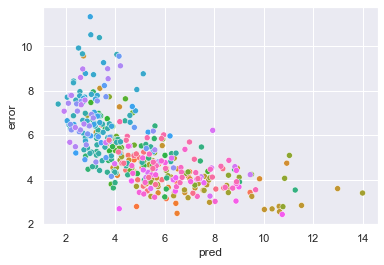

In [268]:
g = sns.scatterplot(data=df_mean_error, x="pred", y="error",  hue="ags5")
g.legend_.remove()

In [269]:
df_mean_error.sort_values(by = ['error'], ascending=False)

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
09372,09,Freistaat Bayern,Cham,2.960000,2.997325,11.327388
09272,09,Freistaat Bayern,Freyung-Grafenau,3.036667,3.021278,10.515966
09180,09,Freistaat Bayern,Garmisch-Partenkirchen,3.340000,3.367071,10.388317
09190,09,Freistaat Bayern,Weilheim-Schongau,2.586667,2.525670,9.919999
09182,09,Freistaat Bayern,Miesbach,2.680000,2.683920,9.657272
...,...,...,...,...,...,...
05119,05,Nordrhein-Westfalen,Oberhausen,10.373333,10.334515,2.682673
04011,04,Bremen,Bremen,10.156667,10.022335,2.655786
05114,05,Nordrhein-Westfalen,Krefeld,10.696667,10.635344,2.557629


<AxesSubplot:xlabel='error', ylabel='Density'>

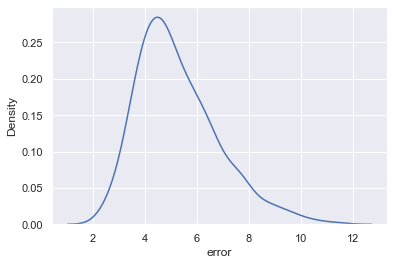

In [270]:
sns.kdeplot(data=df_mean_error, x="error", common_norm=False)

## Look into errors

In [271]:
df.sort_values(by = ['error'], ascending=False)

,date,ground_truth,pred,ags5,ags2,bundesland,kreis,error
7037,2020-05-01,4.7,2.277278,09180,09,Freistaat Bayern,Garmisch-Partenkirchen,51.547273
1583,2020-11-01,2.9,4.280250,03454,03,Niedersachsen,Emsland,47.594835
6797,2020-05-01,4.9,2.793772,09172,09,Freistaat Bayern,Berchtesgadener Land,42.984237
7343,2020-11-01,2.8,4.001814,09190,09,Freistaat Bayern,Weilheim-Schongau,42.921914
9407,2020-05-01,3.6,2.092980,09776,09,Freistaat Bayern,Lindau (Bodensee),41.861667
...,...,...,...,...,...,...,...,...
2011,2019-01-01,9.1,9.099842,05116,05,Nordrhein-Westfalen,Mönchengladbach,0.001742
3615,2020-03-01,3.4,3.400045,06431,06,Hessen,Bergstraße,0.001313
3764,2020-02-01,3.4,3.400039,06436,06,Hessen,Main-Taunus,0.001154
9969,2019-09-01,4.9,4.900013,12063,12,Brandenburg,Havelland,0.000257


In [272]:
df['diff_ground_truth'] = df.groupby('ags5')['ground_truth'].diff(1) 
df['diff_ground_truth_abs'] = df['diff_ground_truth'].abs()

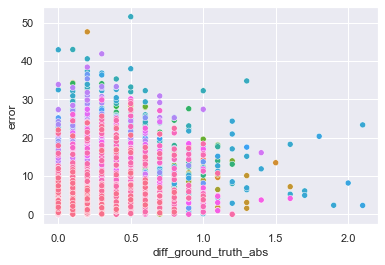

In [273]:
g = sns.scatterplot(data=df, x="diff_ground_truth_abs", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='error', ylabel='Density'>

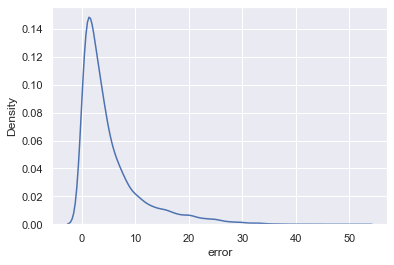

In [274]:
sns.kdeplot(data=df, x="error", common_norm=False)

<AxesSubplot:xlabel='error', ylabel='Density'>

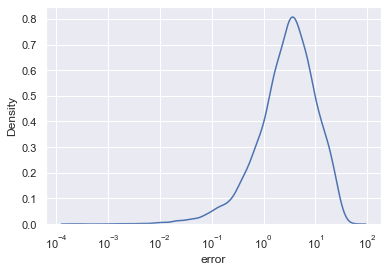

In [275]:
sns.kdeplot(data=df, x="error", common_norm=False,log_scale=True)

# Load structural data

In [276]:
df_structural = pd.read_csv('./../../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )

df_structural["urban_/_rural"] = np.where(df_structural["urban_/_rural"]==1, 'urban', 'rural')
df_structural['eligible_area'] = np.where(df_structural['eligible_area']==1, 'eligible_area', 'not_eligible_area')
df_structural['east_west'] = np.where(df_structural['east_west']==1, 'west', 'east')
df_structural = df_structural.rename(columns={'urban_/_rural': 'urban_rural'})
df_structural

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
0,0,"Flensburg, Stadt",01001,01,92,500,35,240,2901,240,...,2,4,3,rural,99,99,west,1,C,eligible_area
1,2,"Kiel, Landeshauptstadt",01002,01,92,460,37,268,2037,265,...,2,1,2,urban,99,99,west,0,C/D,eligible_area
2,2,"Lübeck, Hansestadt",01003,01,90,532,37,297,1927,294,...,1,1,2,urban,5,99,west,0,C/D,eligible_area
3,0,"Neumünster, Stadt",01004,01,85,588,37,316,1648,313,...,2,3,2,rural,5,99,west,0,D,eligible_area
4,0,Dithmarschen,01051,01,51,1864,35,448,3517,443,...,4,4,3,rural,5,99,west,0,C,eligible_area
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0,Saalfeld-Rudolstadt,16073,16,62,1423,37,341,2492,322,...,3,4,2,rural,99,99,east,0,C*,eligible_area
397,0,Saale-Holzland-Kreis,16074,16,54,1677,38,343,3419,340,...,3,3,2,rural,99,99,east,0,C*,eligible_area
398,0,Saale-Orla-Kreis,16075,16,54,1686,35,449,3172,444,...,3,4,2,rural,99,99,east,2,C*,eligible_area
399,0,Greiz,16076,16,55,1654,38,608,2779,563,...,3,2,2,urban,99,99,east,0,C*,eligible_area


### Merge to df with mean errors

In [277]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5','ags2'])
list(df_mixed.columns)

['ags5',
 'ags2',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Compare error in two_groups

In [278]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    g = sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    g.set_title('MAPE crisis & non-crisis VAR model')
    plt.savefig(f'{column_name}_MAPE_crisis.png')
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]
    return ttest_ind(df_one['error'], df_two['error'], equal_var=False)

Ttest_indResult(statistic=10.58760172413621, pvalue=3.367479114403865e-23)

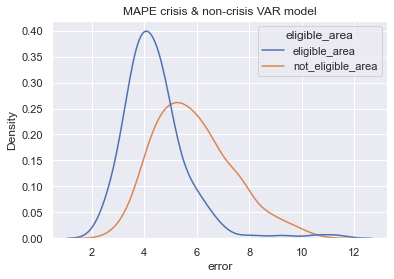

In [279]:
compare_error_in_two_groups(df_mixed, 'eligible_area')

Ttest_indResult(statistic=8.265554765278033, pvalue=1.2247771897595011e-14)

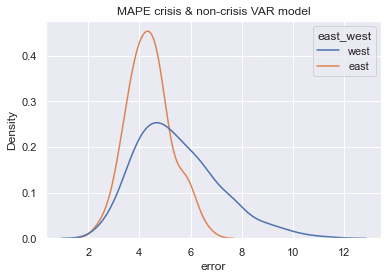

In [280]:
compare_error_in_two_groups(df_mixed, 'east_west')

Ttest_indResult(statistic=-3.4511282478841276, pvalue=0.0006255964617246413)

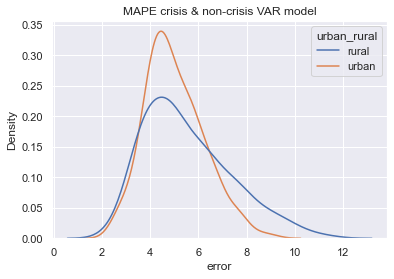

In [281]:
compare_error_in_two_groups(df_mixed, 'urban_rural')

### Compare compare error in multiple groups

In [282]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    mod = ols(f'error ~ {column_name}',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

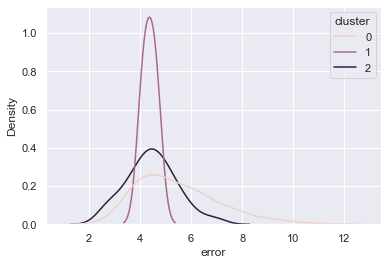

              sum_sq     df          F    PR(>F)
cluster    55.569730    1.0  24.063593  0.000001
Residual  921.405313  399.0        NaN       NaN


In [283]:
compare_error_in_two_groups(df_mixed, "cluster")

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


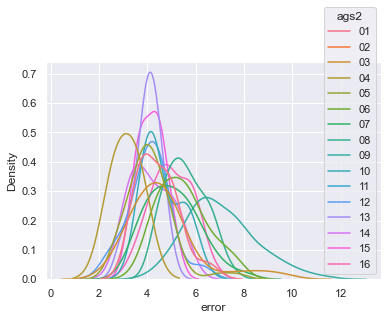

              sum_sq     df          F        PR(>F)
ags2      491.834280   15.0  26.020791  1.531493e-49
Residual  485.140763  385.0        NaN           NaN


In [284]:
compare_error_in_two_groups(df_mixed, "ags2")

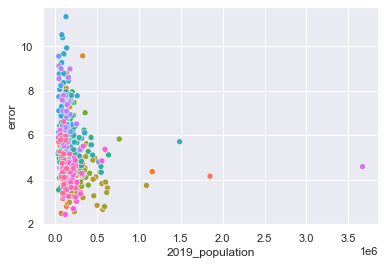

In [285]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

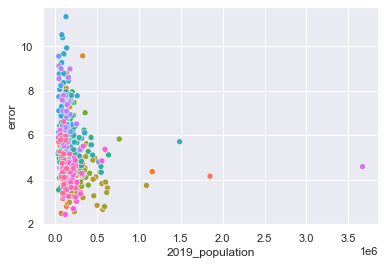

In [286]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

### Linear Regression

In [287]:
df_mixed.set_index('ags5', drop=True, inplace=True)

In [288]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_rural'] = df_mixed['urban_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = np.log(df_mixed['error'])

X = pd.get_dummies(data=X, drop_first=True)

In [289]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [290]:
stats.summary(regr, X, Y, X.columns)

Residuals:
    Min      1Q  Median     3Q    Max
-0.3873 -0.0769 -0.0052 0.0782 0.4352


Coefficients:
                                                   Estimate                  Std. Error          t value   p value
_intercept                                        38.392188  2.637009e+03+6.271113e+04j   0.0000-0.0006j  0.999512
supermarkets_population                           -0.004275  4.968200e-02-4.838000e-03j  -0.0852-0.0083j  0.931788
supermarkets_average_distance                     -0.000126 -3.275000e-03+1.359000e-02j   0.0021+0.0088j  0.992799
public_transport_availability                      0.000284 -1.050500e-02+5.982000e-03j  -0.0204-0.0116j  0.981271
average_distance_bus_stop                          0.000270  1.890000e-04+2.000000e-06j   1.4331-0.0129j  0.152584
average_distance_train_station                    -0.000034 -3.000000e-06+0.000000e+00j  10.8982+0.9683j  0.000000
average_distance_public_transport                 -0.000331  6.300000e-05+9.000000e-06j  -5.

### Sequential Feature Selector

In [291]:
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [292]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(177,)","[-0.2533460179440701, -0.08206654407282898, -0...",-0.134392,"(ags2_09,)",0.122857,0.095587,0.047794
2,"(150, 177)","[-0.051191989121263104, 0.10753534840719725, 0...",0.054923,"(purchasing_power_per_household, ags2_09)",0.156242,0.121562,0.060781
3,"(150, 168, 177)","[0.12767508937058003, 0.18776960900340867, 0.3...",0.111023,"(purchasing_power_per_household, metropolitan_...",0.177226,0.137887,0.068944
4,"(150, 168, 177, 195)","[0.1953378840427108, 0.25140398264245056, 0.42...",0.17118,"(purchasing_power_per_household, metropolitan_...",0.209694,0.163149,0.081574
5,"(147, 150, 168, 177, 195)","[0.20586634086846523, 0.24884506683198304, 0.4...",0.193207,"(standing_water_percentage, purchasing_power_p...",0.191785,0.149215,0.074608
6,"(147, 150, 168, 173, 177, 195)","[0.27097487542165055, 0.22915464623065274, 0.4...",0.22176,"(standing_water_percentage, purchasing_power_p...",0.211213,0.164331,0.082166
7,"(147, 150, 151, 168, 173, 177, 195)","[0.30833337086686674, 0.2621267853447259, 0.50...",0.238267,"(standing_water_percentage, purchasing_power_p...",0.217064,0.168883,0.084442
8,"(1, 147, 150, 151, 168, 173, 177, 195)","[0.3374294963176797, 0.255701824275822, 0.4689...",0.25121,"(supermarkets_average_distance, standing_water...",0.18671,0.145267,0.072633
9,"(1, 147, 150, 151, 164, 168, 173, 177, 195)","[0.3278554753352264, 0.2584892917014793, 0.491...",0.275387,"(supermarkets_average_distance, standing_water...",0.164747,0.128179,0.064089
10,"(1, 139, 147, 150, 151, 164, 168, 173, 177, 195)","[0.3528896391269283, 0.28880507677123324, 0.45...",0.289489,"(supermarkets_average_distance, forrest_area_p...",0.137817,0.107226,0.053613


In [293]:
list(summary_table_select['feature_names'])[:5]

[('ags2_09',),
 ('purchasing_power_per_household', 'ags2_09'),
 ('purchasing_power_per_household', 'metropolitan_area', 'ags2_09'),
 ('purchasing_power_per_household',
  'metropolitan_area',
  'ags2_09',
  'support_area_status_N'),
 ('standing_water_percentage',
  'purchasing_power_per_household',
  'metropolitan_area',
  'ags2_09',
  'support_area_status_N')]

### Ridge

In [294]:
rr = Ridge(alpha=0.5) 
rr.fit(X, Y)

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.95493e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge(alpha=0.5)

In [295]:
stats.summary(rr, X, Y, X.columns)

Residuals:
    Min      1Q  Median     3Q    Max
-0.3832 -0.0798 -0.0057 0.0767 0.4792


Coefficients:
                                                  Estimate                  Std. Error          t value   p value
_intercept                                        7.572245  2.689095e+03+6.394979e+04j   0.0000-0.0001j  0.999906
supermarkets_population                          -0.003903  1.136300e-02+1.633000e-03j  -0.3365+0.0484j  0.734071
supermarkets_average_distance                    -0.000135  3.300000e-03-1.413100e-02j  -0.0021-0.0090j  0.992607
public_transport_availability                     0.000223  1.673100e-02+1.156800e-02j   0.0090-0.0062j  0.991253
average_distance_bus_stop                         0.000237  1.110000e-04+6.000000e-06j   2.1351-0.1193j  0.033085
average_distance_train_station                   -0.000033  4.800000e-05+2.900000e-05j  -0.5032+0.2964j  0.559545
average_distance_public_transport                -0.000299 -1.300000e-05+2.950000e-04j   0.0437+1.0

household_with_kids  
public_transport_per_1000_inhabitants 
number_of_companies_repair_motor_vehicles 
number_of_companies_hospitality
number_of_companies_technical_services
debtor_quota
purchasing_power_per_household

## Look at the variables that are important for predicting the error

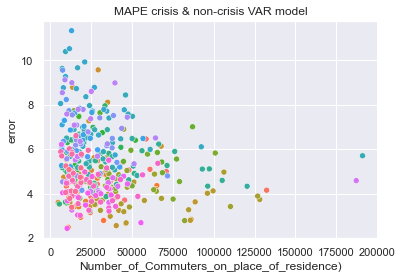

In [296]:
g = sns.scatterplot(data=df_mixed, x="Number_of_Commuters_on_place_of_residence)", y="error",  hue="ags5")
g.set_title('MAPE crisis & non-crisis VAR model')
g.legend_.remove()
plt.savefig('Number_of_Commuters_on_place_of_residence_MAPE_crisis.png')

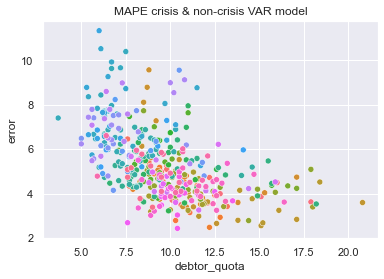

In [297]:
g = sns.scatterplot(data=df_mixed, x="debtor_quota", y="error",  hue="ags5")
g.set_title('MAPE crisis & non-crisis VAR model')
g.legend_.remove()
plt.savefig('debtor_quota_MAPE_crisis.png')

<AxesSubplot:xlabel='debtor_quota', ylabel='Density'>

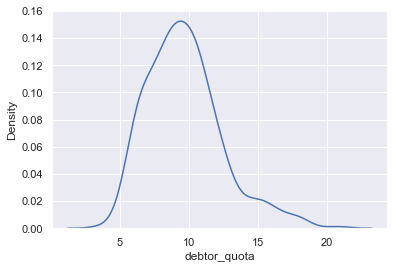

In [298]:
sns.kdeplot(data=df_mixed, x="debtor_quota", common_norm=False)

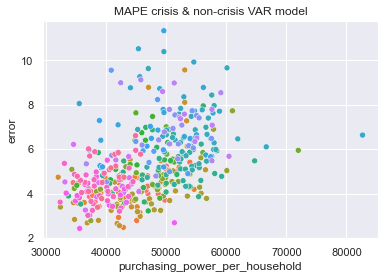

In [299]:
g = sns.scatterplot(data=df_mixed, x="purchasing_power_per_household", y="error",  hue="ags5")
g.set_title('MAPE crisis & non-crisis VAR model')
g.legend_.remove()
plt.savefig('purchasing_power_per_household_MAPE_crisis.png')

<AxesSubplot:xlabel='purchasing_power_per_household', ylabel='Density'>

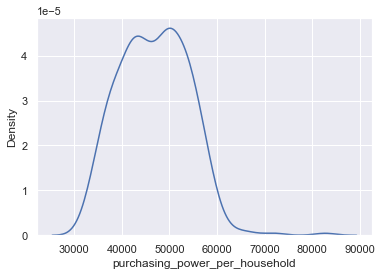

In [300]:
sns.kdeplot(data=df_mixed, x="purchasing_power_per_household", common_norm=False)

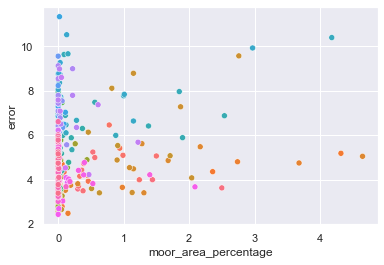

In [301]:
g = sns.scatterplot(data=df_mixed, x="moor_area_percentage", y="error",  hue="ags5")
g.legend_.remove()

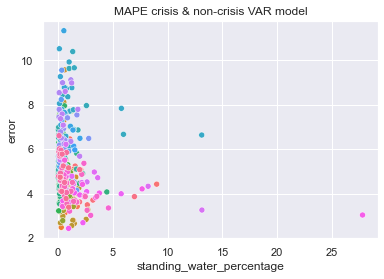

In [302]:
g = sns.scatterplot(data=df_mixed, x="standing_water_percentage", y="error",  hue="ags5")
g.set_title('MAPE crisis & non-crisis VAR model')
g.legend_.remove()
plt.savefig('standing_water_percentage_MAPE_crisis.png')

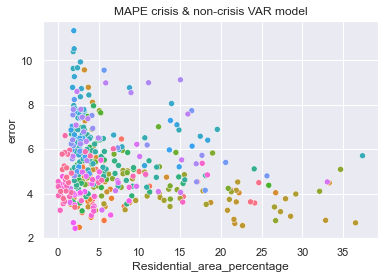

In [305]:
g = sns.scatterplot(data=df_mixed, x="Residential_area_percentage", y="error",  hue="ags5")
g.set_title('MAPE crisis & non-crisis VAR model')
g.legend_.remove()
plt.savefig('metropolitan_area_MAPE_crisis.png')

In [316]:
df_mixed['ags2_09'] =  np.where(df_mixed['ags2']=='09', 'Bayren', 'not Bayren')

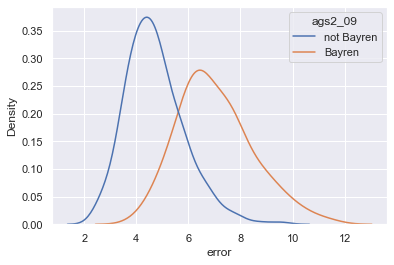

              sum_sq     df           F        PR(>F)
ags2_09   393.050867    1.0  268.574761  1.598326e-46
Residual  583.924176  399.0         NaN           NaN


In [317]:
compare_error_in_two_groups(df_mixed, 'ags2_09')

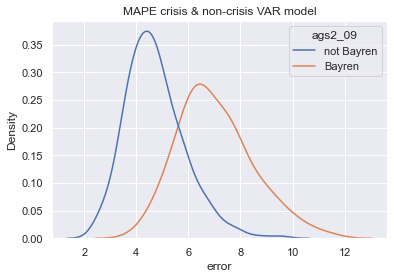

In [320]:
    p = sns.kdeplot(data=df_mixed, x="error", hue='ags2_09',  common_norm=False)
    p.set_title('MAPE crisis & non-crisis VAR model')
    plt.savefig(f'Bayren_MAPE_crisis.png')
    plt.show()

In [313]:
#function to do that cor a spesific column 
def compare_truth_in_two_groups(df, column_name): 
    g = sns.kdeplot(data=df, x="ground_truth", hue=column_name,  common_norm=False)
    g.set_title('Ground truth crisis & non-crisis')
    plt.savefig(f'{column_name}_MAPE_crisis_truth.png')
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]

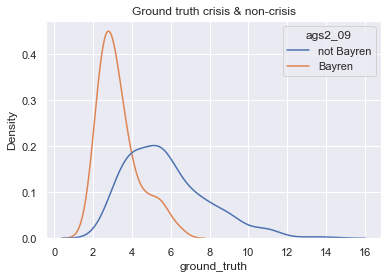

In [314]:
compare_truth_in_two_groups(df_mixed, 'ags2_09')